#### Импортируем нужные модули

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics 

%matplotlib inline

#### Считываем файл и проверяем на пропуски в данных

In [18]:
data_master = pd.read_excel('Test_OOA.xlsx')

In [19]:
data_master.head()

,ID заявки,Тип точки продаж,Кредит_1,Кредит_2,Kредит_3,Клиент_1,Клиент_2,Клиент_3,Клиент_4,Клиент_5,Клиент_6,Клиент_7,Флаг
0,1,2,10,5,5,1,2,0,7,1,12,16,0
1,2,7,3,1,6,2,3,1,7,4,10,15,0
2,3,7,10,1,6,2,4,1,7,4,11,20,0
3,4,7,4,1,10,1,7,1,7,4,8,19,0
4,5,7,6,1,10,2,6,1,7,4,8,3,0


In [20]:
pd.isnull(data_master).values.any()

False

#### Проверим распределение классов

In [21]:
per = len(data_master[data_master.iloc[:,-1]==1])/len(data_master)
print("Отношение плохих заявок ко всем: %s" % per)
print("Всего плохих заявок: %s" % len(data_master[data_master.iloc[:,-1]==1]))

Отношение плохих заявок ко всем: 0.015509710368926819
Всего плохих заявок: 1154


Можно заметить, что данные крайне не сбалансированы, поэтому, в первую очередь, необходимо использовать balanced accuracy в качестве метрики. Кроме того, используем undersampling класса хороших заявок, чтобы сбалансировать классы.

#### Разделим данные

In [22]:
data_master = data_master.sample(frac=1)
data_master = data_master.drop('ID заявки', 1)
target = data_master.iloc[:,-1]
data = data_master.drop('Флаг', 1)

In [23]:
from sklearn.model_selection import train_test_split
X_train_unb, X_test_unb = train_test_split(data, train_size = 0.7, test_size= 0.3, shuffle = False)
y_train_unb, y_test_unb = train_test_split(target, train_size = 0.7, test_size= 0.3, shuffle=False)

In [24]:
y_test_unb.head()

10798    0
17319    0
51998    1
60802    0
18262    0
Name: Флаг, dtype: int64

#### Обучим решающее дерево

Дерево было выбрано мной по нескольким причинам. 
Во-первых, это алгоритм, который наиболее просто позволит интерпретировать решение в виде сегмента условий.
Во-вторых, на вход дерева можно подавать качественные признаки без использования one-hot кодирования, при условии что они упорядочены (например, таким признаком может быть уровень дохода). 
В-третьих, дерево позволяет очевидно контролировать переобучение, огранничивая глубину дерева.

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [176]:
def train_forest(X_tr, y_tr, X_te, y_te):   

    clf_r = DecisionTreeClassifier(max_depth=10, random_state = 5)
    clf_r.fit(X_tr, y_tr)

    pred = clf_r.predict(X_te)

    pred_proba = clf_r.predict_proba(X_te)
    pred_proba = pred_proba[:, 1]

    for i in range(0, len(pred)):
        if pred_proba[i]>0.5:
            pred[i]=1
        else: 
            pred[i]=0

    bal_acc = metrics.balanced_accuracy_score(y_te, pred)
    auc_roc = metrics.roc_auc_score(y_te, pred_proba)

    #print("Balanced accuracy: ", bal_acc)
    #print("AUC-ROC: ", auc_roc)
    
    return pred, clf_r, bal_acc, auc_roc

In [90]:
_, tree, bal, auc = train_forest(X_train_unb, y_train_unb, X_test_unb, y_test_unb)
print("Balanced accuracy: %s" %bal)
print("AUC_ROC: %s" %auc)

Balanced accuracy: 0.5098253813032536
AUC_ROC: 0.9065275034329204


#### Попробуем добавить undersampling, искуственно уменьшив количество "хороших" заявок в обучающей выборке
Выбранное соотношение "хороших" заявок к "плохим" примерно 1 к 10 (что тоже не очень классно, но уже лучше).

In [91]:
good_indices = data_master[data_master.iloc[:,-1] == 0].index
random_indices = np.random.choice(good_indices, 10000, replace=False)
good_sample = data_master.loc[random_indices]

bad_sample = data_master[data_master.iloc[:,-1]==1]

In [92]:
undersampled = good_sample.append(bad_sample)
undersampled = undersampled.sample(frac=1)

In [93]:
target = undersampled.iloc[:,-1]
data = undersampled.drop('Флаг', 1)

X_train, X_test = train_test_split(data, train_size = 0.7, test_size= 0.3, shuffle = False)
y_train, y_test = train_test_split(target, train_size = 0.7, test_size= 0.3, shuffle=False)

In [253]:
prediction, tree, bal, auc = train_forest(X_train, y_train, X_test_unb, y_test_unb)
print("Balanced accuracy: %s" %bal)
print("AUC_ROC: %s" %auc)

Balanced accuracy: 0.7616891214322534
AUC_ROC: 0.9374055134652787


Качество алгоритма улучшилось!

#### Визуализируем дерево из леса, чтобы посмотреть на признаки

In [306]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', 
                feature_names = data.columns.tolist(),
                class_names = ["0", "1"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)


#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.system('dot -Tpng tree.dot -o tree.png')


#from IPython.display import Image
#Image(filename = 'tree.png')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], <a list of 11 Text xticklabel objects>)

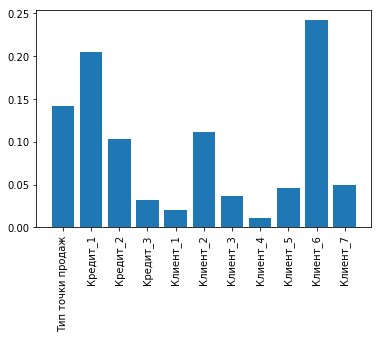

In [98]:
plt.bar(X_train.columns, tree.feature_importances_)
plt.xticks(rotation=90)

#### Будем отбирать признаки таким образом, чтобы выделить сегмент объемом не более 1/3 от всех заявок

In [277]:
#Выделим вершины, в которые попало не больше 1/3 данных.

import sklearn.tree
import collections

fitted_data = X_train
fitting_data = X_test_unb
predicted_data = prediction

samples = collections.defaultdict(list)
dec_paths = tree.decision_path(fitting_data)


acceptable_nodes = np.where((tree.tree_.n_node_samples/len(fitted_data) <= 0.333)==True)[0]

In [298]:
#создадим словарь, где ключами являются номера узлов, а значениями номера данных из выборки
for d, dec in enumerate(dec_paths):
    for i in range(tree.tree_.node_count):
        if dec.toarray()[0][i]  == 1:
            samples[i].append(d) 

In [282]:
#проверим предсказания для всех строк, попавших в подходящие нам вершины

predictions_in_nodes = []
pred = []

for node in acceptable_nodes:
    pred = []
    samples_in_node = samples[node]
    for sample in samples_in_node:
        pred.append(prediction[sample])
    total_pred = sum(pred) #quantity of bad credits in node
    predictions_in_nodes.append(total_pred) 

In [283]:
#выберем вершину с наибольшим количеством "плохих" заявок

best_node = np.argmax(predictions_in_nodes)
best_node = acceptable_nodes[best_node]
best_node

274

In [284]:
#пропарсим структуру нашего дерева

n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right
feature = tree.tree_.feature
threshold = tree.tree_.threshold

In [286]:
#оформим структуру дерева в виде текста, чтобы потом найти в нем путь до нужной вершины

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
        if (children_left[i]==best_node or children_right[i]==best_node):
            break
print()

The binary tree structure has 425 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 9] <= 9.5 else to node 114.
	node=1 test node: go to node 2 if X[:, 9] <= 8.5 else to node 49.
		node=2 test node: go to node 3 if X[:, 9] <= 2.5 else to node 10.
			node=3 test node: go to node 4 if X[:, 2] <= 4.5 else to node 9.
				node=4 test node: go to node 5 if X[:, 2] <= 2.0 else to node 6.
					node=5 leaf node.
					node=6 test node: go to node 7 if X[:, 7] <= 4.5 else to node 8.
						node=7 leaf node.
						node=8 leaf node.
				node=9 leaf node.
			node=10 test node: go to node 11 if X[:, 5] <= 3.5 else to node 40.
				node=11 test node: go to node 12 if X[:, 9] <= 7.5 else to node 23.
					node=12 test node: go to node 13 if X[:, 2] <= 2.5 else to node 14.
						node=13 leaf node.
						node=14 test node: go to node 15 if X[:, 5] <= 2.5 else to node 16.
							node=15 leaf node.
							node=16 test node: go to node 17 if X[:, 2] <= 3.5 else to node 22.
				

Из структуры можно вывести сегмент в виде: 

«Клиент_6 in [10, 31] AND Тип точки продаж in [5, 10] AND Кредит_1 in [7, 30]»

In [305]:
#проверим, какое количество "плохих" заявок находится в выделенном сегменте

test = data_master[data_master['Клиент_6']>9]
test = test[test['Тип точки продаж']>4]
test = test[test['Кредит_1']>6]
print("Всего плохих заявок в сегменте: %s" %sum(test['Флаг']))

Всего плохих заявок в сегменте: 701
